<a href="https://colab.research.google.com/github/zhaohongwei1998/SimCSE/blob/main/Multi_Hop_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

multi-hop版本

In [ ]:
!/opt/bin/nvidia-smi

Thu Feb 10 04:12:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    33W / 250W |   4239MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install gdown
!gdown https://drive.google.com/uc?id=12HbavGOtoVCqicvSYWl3zImli5Jz0Nou
!gdown https://drive.google.com/uc?id=1VJhSc2TGrPU8zJSVTYwn5kfuG47VaNQ3


Downloading...
From: https://drive.google.com/uc?id=12HbavGOtoVCqicvSYWl3zImli5Jz0Nou
To: /content/mosi.pkl
100% 14.2M/14.2M [00:00<00:00, 175MB/s]
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1VJhSc2TGrPU8zJSVTYwn5kfuG47VaNQ3 



In [ ]:

!pip install transformers

Downloading...
From: https://drive.google.com/uc?id=12HbavGOtoVCqicvSYWl3zImli5Jz0Nou
To: /content/mosi.pkl
100% 14.2M/14.2M [00:00<00:00, 169MB/s]
Downloading...
From: https://drive.google.com/uc?id=1VJhSc2TGrPU8zJSVTYwn5kfuG47VaNQ3
To: /content/mosei.pkl
100% 508M/508M [00:01<00:00, 302MB/s]


In [ ]:
max_seq_length = 50
acoustic_dim = 74
visual_dim = 47
train_batch_size = 32
dev_batch_size = 32
test_batch_size = 32
n_epochs = 40
att_dropout = 0.1
state_dropout = 0.2

In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import math
DEVICE = torch.device("cuda:0")

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.t_lstm = nn.LSTM(768, 100, bidirectional=True, batch_first=True)
        self.a_lstm = nn.LSTM(74, 100, bidirectional=True, batch_first=True)
        self.v_lstm = nn.LSTM(47, 100, bidirectional=True, batch_first=True)
        self.t_linear = nn.Linear(2,1,bias=False)
        self.a_linear = nn.Linear(2, 1, bias=False)
        self.v_linear = nn.Linear(2, 1, bias=False)
        self.at = Uni_Hop()
        self.ta = Uni_Hop()

        self.vt = Uni_Hop()
        self.tv = Uni_Hop()

        self.avt = Uni_Hop()
        self.tav = Uni_Hop()

        self.linear = nn.Linear(100, 1)

    def forward(self, input_ids, segment_ids, input_mask, acoustic, visual):
        # t
        out = self.bert(input_ids=input_ids, attention_mask=input_mask, token_type_ids=segment_ids)
        text = out[0]
        lengths = torch.sum(input_mask, dim=1).tolist()
        t_pack = pack_padded_sequence(text, lengths, batch_first=True, enforce_sorted=False)
        t_rnn, _ = self.t_lstm(t_pack)
        t_unpack = pad_packed_sequence(t_rnn,batch_first=True,total_length=50)
        t_unpack = t_unpack[0]
        t_unpack = t_unpack.view(t_unpack.size(0), t_unpack.size(1), 2, 100)
        t_unpack = t_unpack.transpose(-1,-2)
        t_unpack = self.t_linear(t_unpack)
        t_unpack = torch.squeeze(t_unpack)
        # t_unpack,_=self.t_lstm(text)
        # a
        a_pack = pack_padded_sequence(acoustic, lengths, batch_first=True, enforce_sorted=False)
        a_rnn, _ = self.a_lstm(a_pack)
        a_unpack = pad_packed_sequence(a_rnn,batch_first=True, total_length=50)
        a_unpack = a_unpack[0]
        a_unpack = a_unpack.view(a_unpack.size(0), a_unpack.size(1), 2, 100)
        a_unpack = a_unpack.transpose(-1, -2)
        a_unpack = self.a_linear(a_unpack)
        a_unpack = torch.squeeze(a_unpack)
        # v
        v_pack = pack_padded_sequence(visual, lengths, batch_first=True, enforce_sorted=False)
        v_rnn, _ = self.v_lstm(v_pack)
        v_unpack = pad_packed_sequence(v_rnn,batch_first=True, total_length=50)
        v_unpack= v_unpack[0]
        v_unpack = v_unpack.view(v_unpack.size(0), v_unpack.size(1), 2, 100)
        v_unpack = v_unpack.transpose(-1, -2)
        v_unpack = self.v_linear(v_unpack)
        v_unpack = torch.squeeze(v_unpack)

        ta = self.ta(t_unpack,a_unpack,input_mask)
        at = self.at(ta, t_unpack, input_mask)
        tv = self.tv(t_unpack,v_unpack,input_mask)
        vt = self.vt(tv, t_unpack, input_mask)
        avt = self.avt(at, vt, input_mask)
        tav = self.tav(avt,vt,input_mask)
        tav = tav[:,0,:]
        output = self.linear(tav)

        return output


class Uni_Hop(nn.Module):
    def __init__(self):
        super().__init__()
        self.Wq = nn.Linear(100, 100)
        self.Wk = nn.Linear(100, 100)
        self.Wv = nn.Linear(100, 100)
        self.att_drop = nn.Dropout(att_dropout)
        self.state_drop = nn.Dropout(state_dropout)
        self.ln = nn.LayerNorm(100)

    def calc_mask_score(self, attention_mask):
        # input_size b*n
        # output_size b*n*n

        mask_score = torch.zeros(attention_mask.size(0), attention_mask.size(1), attention_mask.size(1)).to(DEVICE)
        mask_score = mask_score + attention_mask[:, :, None]
        mask_score = (1.0 - mask_score) * -10000
        return mask_score

    def forward(self, q, k_v, attention_mask):
        Q = self.Wq(q)
        K = self.Wk(k_v)
        V = self.Wv(k_v)

        attention_score = torch.matmul(Q, K.transpose(-1, -2)) / math.sqrt(100)
        attention_score = attention_score + self.calc_mask_score(attention_mask)
        attention_score = nn.Softmax(dim=-1)(attention_score)
        attention_score = self.att_drop(attention_score)

        O = torch.matmul(attention_score, V)
        O = self.state_drop(O)
        O = self.ln(k_v + O)
        return O


In [ ]:
import pickle
import torch
#from net import Net

from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import torch
import torch.nn as nn
from transformers.optimization import AdamW
from transformers import get_linear_schedule_with_warmup
from transformers import BertTokenizer
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import pickle as pkl
from matplotlib import pyplot as plt
DEVICE = torch.device("cuda:0")
#DEVICE = torch.device("cpu")
with open(f"mosi.pkl",mode="rb") as handle:
  data = pickle.load(handle)
train_data = data["train"]
dev_data = data["dev"]
test_data = data["test"]
# print(len(train_data))


gradient_accumulation_step = 1
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
def prep_train_dataloader():
    features = []
    for (ex_index, example) in enumerate(train_data):
        (words, visual, acoustic), label_id, segment = example
        tokens, inversions = [], []
        # print("visual.shape", visual.shape)
        # print("acoustic.shape", acoustic.shape)
        # print(words)
        for (idx, word) in enumerate(words):
            tokenized = tokenizer.tokenize(word)
            tokens.extend(tokenized)
            inversions.extend([idx] * len(tokenized))
            # print(tokenized)
        # if ex_index == 5:
        #   break

        aligned_visual = []
        aligned_acoustic = []
        for inv_idx in inversions:
            aligned_visual.append(visual[inv_idx, :])
            aligned_acoustic.append(acoustic[inv_idx, :])

        visual = np.array(aligned_visual)
        acoustic = np.array(aligned_acoustic)

        if len(tokens) > max_seq_length - 2:
            tokens = tokens[: max_seq_length - 2]
            acoustic = acoustic[: max_seq_length - 2]
            visual = visual[: max_seq_length - 2]

        # 将token进行转换
        CLS = tokenizer.cls_token
        SEP = tokenizer.sep_token
        tokens = [CLS] + tokens + [SEP]
        acoustic_zero = np.zeros((1, acoustic_dim))
        visual_zero = np.zeros((1, visual_dim))
        acoustic = np.concatenate((acoustic_zero, acoustic, acoustic_zero))
        visual = np.concatenate((visual_zero, visual, visual_zero))

        input_ids = tokenizer.convert_tokens_to_ids(tokens)
        segment_ids = [0] * len(input_ids)
        input_mask = [1] * len(input_ids)

        # 加PAD
        pad_length = max_seq_length - len(input_ids)
        acoustic_padding = np.zeros((pad_length, acoustic_dim))
        acoustic = np.concatenate((acoustic, acoustic_padding))

        visual_padding = np.zeros((pad_length, visual_dim))
        visual = np.concatenate((visual, visual_padding))

        padding = [0] * pad_length
        input_ids += padding
        input_mask += padding
        segment_ids += padding
        features.append((input_ids, segment_ids, input_mask, acoustic, visual, label_id))

    # 把数组列表转换为tensor类型
    all_input_ids = torch.tensor([f[0] for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f[1] for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f[2] for f in features], dtype=torch.long)
    all_acoustic = torch.tensor([f[3] for f in features], dtype=torch.float)
    all_visual = torch.tensor([f[4] for f in features], dtype=torch.float)
    all_label_ids = torch.tensor([f[5] for f in features], dtype=torch.float)

    train_dataset = TensorDataset(all_input_ids, all_segment_ids, all_input_mask, all_acoustic, all_visual, all_label_ids)
    train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    num_train_optimization_steps = (int(len(train_dataset) / train_batch_size / gradient_accumulation_step) * n_epochs)
    return num_train_optimization_steps,train_dataloader

def prep_dev_dataloader():
    features = []
    for (ex_index, example) in enumerate(dev_data):
        (words, visual, acoustic), label_id, segment = example
        tokens, inversions = [], []
        # print("visual.shape", visual.shape)
        # print("acoustic.shape", acoustic.shape)
        # print(words)
        for (idx, word) in enumerate(words):
            tokenized = tokenizer.tokenize(word)
            tokens.extend(tokenized)
            inversions.extend([idx] * len(tokenized))
            # print(tokenized)
        # if ex_index == 5:
        #   break

        aligned_visual = []
        aligned_acoustic = []
        for inv_idx in inversions:
            aligned_visual.append(visual[inv_idx, :])
            aligned_acoustic.append(acoustic[inv_idx, :])

        visual = np.array(aligned_visual)
        acoustic = np.array(aligned_acoustic)

        if len(tokens) > max_seq_length - 2:
            tokens = tokens[: max_seq_length - 2]
            acoustic = acoustic[: max_seq_length - 2]
            visual = visual[: max_seq_length - 2]

        # 将token进行转换
        CLS = tokenizer.cls_token
        SEP = tokenizer.sep_token
        tokens = [CLS] + tokens + [SEP]
        acoustic_zero = np.zeros((1, acoustic_dim))
        visual_zero = np.zeros((1, visual_dim))
        acoustic = np.concatenate((acoustic_zero, acoustic, acoustic_zero))
        visual = np.concatenate((visual_zero, visual, visual_zero))

        input_ids = tokenizer.convert_tokens_to_ids(tokens)
        segment_ids = [0] * len(input_ids)
        input_mask = [1] * len(input_ids)

        # 加PAD
        pad_length = max_seq_length - len(input_ids)
        acoustic_padding = np.zeros((pad_length, acoustic_dim))
        acoustic = np.concatenate((acoustic, acoustic_padding))

        visual_padding = np.zeros((pad_length, visual_dim))
        visual = np.concatenate((visual, visual_padding))

        padding = [0] * pad_length
        input_ids += padding
        input_mask += padding
        segment_ids += padding
        features.append((input_ids, segment_ids, input_mask, acoustic, visual, label_id))

    # 把数组列表转换为tensor类型
    all_input_ids = torch.tensor([f[0] for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f[1] for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f[2] for f in features], dtype=torch.long)
    all_acoustic = torch.tensor([f[3] for f in features], dtype=torch.float)
    all_visual = torch.tensor([f[4] for f in features], dtype=torch.float)
    all_label_ids = torch.tensor([f[5] for f in features], dtype=torch.float)

    dev_dataset = TensorDataset(all_input_ids, all_segment_ids, all_input_mask, all_acoustic, all_visual,
                                  all_label_ids)
    dev_dataloader = DataLoader(dev_dataset, batch_size=dev_batch_size, shuffle=True)
    return dev_dataloader
def prep_test_dataloader():
    features = []
    for (ex_index, example) in enumerate(test_data):
        (words, visual, acoustic), label_id, segment = example
        tokens, inversions = [], []
        # print("visual.shape", visual.shape)
        # print("acoustic.shape", acoustic.shape)
        # print(words)
        for (idx, word) in enumerate(words):
            tokenized = tokenizer.tokenize(word)
            tokens.extend(tokenized)
            inversions.extend([idx] * len(tokenized))
            # print(tokenized)
        # if ex_index == 5:
        #   break

        aligned_visual = []
        aligned_acoustic = []
        for inv_idx in inversions:
            aligned_visual.append(visual[inv_idx, :])
            aligned_acoustic.append(acoustic[inv_idx, :])

        visual = np.array(aligned_visual)
        acoustic = np.array(aligned_acoustic)

        if len(tokens) > max_seq_length - 2:
            tokens = tokens[: max_seq_length - 2]
            acoustic = acoustic[: max_seq_length - 2]
            visual = visual[: max_seq_length - 2]

        # 将token进行转换
        CLS = tokenizer.cls_token
        SEP = tokenizer.sep_token
        tokens = [CLS] + tokens + [SEP]
        acoustic_zero = np.zeros((1, acoustic_dim))
        visual_zero = np.zeros((1, visual_dim))
        acoustic = np.concatenate((acoustic_zero, acoustic, acoustic_zero))
        visual = np.concatenate((visual_zero, visual, visual_zero))

        input_ids = tokenizer.convert_tokens_to_ids(tokens)
        segment_ids = [0] * len(input_ids)
        input_mask = [1] * len(input_ids)

        # 加PAD
        pad_length = max_seq_length - len(input_ids)
        acoustic_padding = np.zeros((pad_length, acoustic_dim))
        acoustic = np.concatenate((acoustic, acoustic_padding))

        visual_padding = np.zeros((pad_length, visual_dim))
        visual = np.concatenate((visual, visual_padding))

        padding = [0] * pad_length
        input_ids += padding
        input_mask += padding
        segment_ids += padding
        features.append((input_ids, segment_ids, input_mask, acoustic, visual, label_id))

    # 把数组列表转换为tensor类型
    all_input_ids = torch.tensor([f[0] for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f[1] for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f[2] for f in features], dtype=torch.long)
    all_acoustic = torch.tensor([f[3] for f in features], dtype=torch.float)
    all_visual = torch.tensor([f[4] for f in features], dtype=torch.float)
    all_label_ids = torch.tensor([f[5] for f in features], dtype=torch.float)

    test_dataset = TensorDataset(all_input_ids, all_segment_ids, all_input_mask, all_acoustic, all_visual,
                                  all_label_ids)
    test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)
    return test_dataloader

# preparing for train:optimizer, schedular
# optimizer
def prep_for_training(num_train_optimization_steps):
    model = Net()
    model.to(DEVICE)


    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [
                p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.01
        },
        {
            "params": [
                p for n, p in param_optimizer if any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.0
        }
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5)

    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0.1 * num_train_optimization_steps,
                                                num_training_steps=num_train_optimization_steps)
    return model, optimizer, scheduler

# train_epoch
from torch.nn import MSELoss
from tqdm import tqdm

def train_epoch(model:nn.Module, train_dataloader:DataLoader, optimizer, scheduler):
    model.train()
    tr_loss = 0
    nb_tr_steps = 0
    for step, batch in enumerate(tqdm(train_dataloader, desc="Iteration")):
        batch = tuple(t.to(DEVICE) for t in batch)
        input_ids, segment_ids, input_mask, acoustic, visual, label_ids = batch
        output = model(input_ids=input_ids, segment_ids=segment_ids, input_mask=input_mask, acoustic=acoustic, visual=visual)
        loss_func = MSELoss()
        loss = loss_func(output.view(-1),label_ids.view(-1))
        loss.backward()
        tr_loss += loss.item()
        nb_tr_steps += 1
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return tr_loss/nb_tr_steps

def dev_epoch(model,dev_dataloader):
    model.eval()
    dev_loss = 0
    nb_dev_steps = 0

    with torch.no_grad():
        for step, batch in enumerate(tqdm(dev_dataloader,desc="Iteration")):
            batch = tuple(t.to(DEVICE) for t in batch)
            input_ids, segment_ids, input_mask, acoustic, visual, label_ids = batch
            output = model(input_ids=input_ids, segment_ids=segment_ids, input_mask=input_mask, acoustic=acoustic,
                           visual=visual)
            loss_func = MSELoss()
            loss = loss_func(output.view(-1), label_ids.view(-1))
            dev_loss+=loss.item()
            nb_dev_steps += 1
    return dev_loss/nb_dev_steps

def test_epoch(model,test_dataloader):
    model.eval()
    preds = []
    labels = []

    with torch.no_grad():
        for batch in tqdm(test_dataloader):
            batch = tuple(t.to(DEVICE) for t in batch)
            input_ids, segment_ids, input_mask, acoustic, visual, label_ids = batch
            output = model(input_ids=input_ids, segment_ids=segment_ids, input_mask=input_mask, acoustic=acoustic,
                           visual=visual)
            pred= output.detach().cpu().numpy()
            label =label_ids.detach().cpu().numpy()

            pred =np.squeeze(pred).tolist()
            label = np.squeeze(label).tolist()
            preds.extend(pred)
            labels.extend(label)
    preds=np.array(preds)
    labels = np.array(labels)
    return preds, labels
def test_score(model,test_dataloader):
    preds, y_test =test_epoch(model,test_dataloader)
    non_zeros =np.array([i for i,e in enumerate(y_test) if e!=0])
    preds_non = preds[non_zeros]
    y_test_non = y_test[non_zeros]
    #回归
    mae_non = np.mean(np.absolute(preds_non-y_test_non))
    corr_non =np.corrcoef(preds_non,y_test_non)[0][1]
    #分类
    preds_non = preds_non>=0
    y_test_non = y_test_non>=0
    acc_non = accuracy_score(y_test_non, preds_non)
    f_score_non =f1_score(y_test_non,preds_non,average="weighted")

    #acc,f_score
    preds = preds>=0
    y_test = y_test>=0
    acc = accuracy_score(y_test,preds)
    f_score = f1_score(y_test,preds)

    return mae_non,corr_non,acc,acc_non,f_score,f_score_non



In [ ]:
train_losses = []
dev_losses = []
test_maes = []
test_corrs = []
test_accs = []
test_accs_non = []
test_f_scores = []
test_f_scores_non = []

num_train_optimization_steps,train_dataloader = prep_train_dataloader()
dev_dataloader = prep_dev_dataloader()
test_dataloader = prep_test_dataloader()
model, optimizer, scheduler = prep_for_training(num_train_optimization_steps)
for epoch_i in range(n_epochs):
    train_loss = train_epoch(model,train_dataloader,optimizer,scheduler)
    dev_loss = dev_epoch(model,dev_dataloader)
    test_mae,test_corr,test_acc,test_acc_non,test_f_score,test_f_score_non = test_score(model,test_dataloader)
    print(str(epoch_i)+" "+str(train_loss)+" "+str(dev_loss)+" "+str(test_acc))

    train_losses.append(train_loss)
    dev_losses.append(dev_loss)
    test_maes.append(test_mae)
    test_corrs.append(test_corr)
    test_accs.append(test_acc)
    test_accs_non.append(test_acc_non)
    test_f_scores.append(test_f_score)
    test_f_scores_non.append(test_f_score_non)
result = pd.DataFrame({"train_losses":train_losses, "dev_losses":dev_losses,
            "test_maes":test_maes, "test_corrs":test_corrs,
            "test_accs":test_accs,"test_accs_non":test_accs_non,
                        "test_f_scores":test_f_scores,"test_f_scores_non":test_f_scores_non})
with open("./result.pkl", "wb") as f:
    pkl.dump(result,f)



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a

0 2.6044752510582527 3.3225592970848083 0.5299270072992701


100%|██████████| 22/22 [00:01<00:00, 16.24it/s]


1 2.4510699626876087 2.7573190182447433 0.5474452554744526


100%|██████████| 22/22 [00:01<00:00, 16.29it/s]


2 2.3402579732057527 2.7172546088695526 0.5605839416058395


100%|██████████| 22/22 [00:01<00:00, 16.18it/s]


3 2.1595889547976053 2.855980336666107 0.6043795620437956


100%|██████████| 22/22 [00:01<00:00, 16.21it/s]


4 2.0996018880751075 2.821631997823715 0.6408759124087591


100%|██████████| 22/22 [00:01<00:00, 16.21it/s]


5 1.95358641845424 2.353085905313492 0.6613138686131387


100%|██████████| 22/22 [00:01<00:00, 16.30it/s]


6 1.8040295054272908 2.206400766968727 0.6832116788321168


100%|██████████| 22/22 [00:01<00:00, 16.23it/s]


7 1.706514942936781 1.9464424550533295 0.6963503649635037


100%|██████████| 22/22 [00:01<00:00, 16.36it/s]


8 1.3578602140996514 1.8600758910179138 0.745985401459854


100%|██████████| 22/22 [00:01<00:00, 16.36it/s]


9 1.1550916476947506 1.5789456367492676 0.7839416058394161


100%|██████████| 22/22 [00:01<00:00, 16.29it/s]


10 0.965998661772507 1.416268765926361 0.7897810218978102


100%|██████████| 22/22 [00:01<00:00, 16.22it/s]


11 0.8148028792404547 1.2998329848051071 0.7985401459854015


100%|██████████| 22/22 [00:01<00:00, 16.28it/s]


12 0.6831907714240071 1.3610754758119583 0.8058394160583942


100%|██████████| 22/22 [00:01<00:00, 16.14it/s]


13 0.6240132934436565 1.2389625161886215 0.8029197080291971


100%|██████████| 22/22 [00:01<00:00, 16.25it/s]


14 0.6488805296944409 1.2458514869213104 0.8072992700729927


100%|██████████| 22/22 [00:01<00:00, 16.16it/s]


15 0.508247591373397 1.2940705046057701 0.8058394160583942


100%|██████████| 22/22 [00:01<00:00, 16.33it/s]


16 0.4319934860417029 1.4616830796003342 0.8072992700729927


100%|██████████| 22/22 [00:01<00:00, 16.10it/s]


17 0.4038798296596946 1.296626254916191 0.8058394160583942


100%|██████████| 22/22 [00:01<00:00, 16.22it/s]


18 0.32912445958794617 1.434586226940155 0.8058394160583942


100%|██████████| 22/22 [00:01<00:00, 16.33it/s]


19 0.30340131208664034 1.2717732042074203 0.8029197080291971


100%|██████████| 22/22 [00:01<00:00, 16.26it/s]


20 0.2874627120611144 1.2852067053318024 0.8072992700729927


100%|██████████| 22/22 [00:01<00:00, 16.14it/s]


21 0.24947320760750188 1.2488711178302765 0.8043795620437956


100%|██████████| 22/22 [00:01<00:00, 16.23it/s]


22 0.23482508503082322 1.383724369108677 0.8145985401459854


100%|██████████| 22/22 [00:01<00:00, 16.19it/s]


23 0.23080871417755033 1.5392065718770027 0.8072992700729927


100%|██████████| 22/22 [00:01<00:00, 16.27it/s]


24 0.17627992771747636 1.2045859396457672 0.8102189781021898


100%|██████████| 22/22 [00:01<00:00, 16.16it/s]


25 0.17433181495928182 1.1880019195377827 0.8072992700729927


100%|██████████| 22/22 [00:01<00:00, 16.20it/s]


26 0.18951923963500233 1.1827648654580116 0.8116788321167884


100%|██████████| 22/22 [00:01<00:00, 16.26it/s]


27 0.16765551977768178 1.3088858872652054 0.8145985401459854


100%|██████████| 22/22 [00:01<00:00, 16.27it/s]


28 0.1584459152526972 1.2581790089607239 0.8175182481751825


100%|██████████| 22/22 [00:01<00:00, 16.24it/s]


29 0.15332840873700818 1.162405602633953 0.8102189781021898


100%|██████████| 22/22 [00:01<00:00, 16.29it/s]


30 0.13824609417195727 1.280308410525322 0.8087591240875912


100%|██████████| 22/22 [00:01<00:00, 16.16it/s]


31 0.13147099334292295 1.0971061326563358 0.8131386861313868


100%|██████████| 22/22 [00:01<00:00, 16.27it/s]


32 0.12932723274499905 1.2100250124931335 0.8087591240875912


100%|██████████| 22/22 [00:01<00:00, 16.27it/s]


33 0.11446164904173645 1.5117463245987892 0.8145985401459854


100%|██████████| 22/22 [00:01<00:00, 16.20it/s]


34 0.11282075232848889 1.1804331839084625 0.8029197080291971


100%|██████████| 22/22 [00:01<00:00, 16.33it/s]


35 0.12519806264558944 1.1576776057481766 0.8189781021897811


100%|██████████| 22/22 [00:01<00:00, 16.19it/s]


36 0.10566008499100883 1.23919178545475 0.8145985401459854


100%|██████████| 22/22 [00:01<00:00, 16.32it/s]


37 0.09869750302920981 1.119416780769825 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.29it/s]


38 0.09884669731666403 1.3992024213075638 0.8087591240875912


100%|██████████| 22/22 [00:01<00:00, 16.31it/s]


39 0.09680923107136949 1.102143194526434 0.8204379562043795


100%|██████████| 22/22 [00:01<00:00, 16.31it/s]


40 0.09794452650154509 1.2938001453876495 0.8087591240875912


100%|██████████| 22/22 [00:01<00:00, 16.33it/s]


41 0.09174958094045883 1.1586775705218315 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.18it/s]


42 0.08996675154421388 1.09795949049294 0.8145985401459854


100%|██████████| 22/22 [00:01<00:00, 16.17it/s]


43 0.08617405557050938 1.0593146570026875 0.8277372262773722


100%|██████████| 22/22 [00:01<00:00, 16.30it/s]


44 0.08760428365047385 1.077887512743473 0.8233576642335766


100%|██████████| 22/22 [00:01<00:00, 16.30it/s]


45 0.09113080272587334 1.0467773098498583 0.8116788321167884


100%|██████████| 22/22 [00:01<00:00, 16.21it/s]


46 0.0859860585003001 1.1278496608138084 0.8145985401459854


100%|██████████| 22/22 [00:01<00:00, 16.20it/s]


47 0.08267463616481642 1.0570563934743404 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.33it/s]


48 0.07742641266526246 1.1237626746296883 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.35it/s]


49 0.07867926833923997 1.0713950954377651 0.8233576642335766


100%|██████████| 22/22 [00:01<00:00, 16.04it/s]


50 0.07703030545537065 1.1217524409294128 0.8204379562043795


100%|██████████| 22/22 [00:01<00:00, 16.20it/s]


51 0.08057555856137741 1.0809558108448982 0.8248175182481752


100%|██████████| 22/22 [00:01<00:00, 16.29it/s]


52 0.07180557129677476 1.0382293723523617 0.8233576642335766


100%|██████████| 22/22 [00:01<00:00, 16.34it/s]


53 0.07790751282761736 1.1154943779110909 0.8189781021897811


100%|██████████| 22/22 [00:01<00:00, 16.34it/s]


54 0.07768377608324332 1.123988889157772 0.8291970802919708


100%|██████████| 22/22 [00:01<00:00, 16.24it/s]


55 0.06506246087572924 1.1413336768746376 0.8189781021897811


100%|██████████| 22/22 [00:01<00:00, 16.13it/s]


56 0.0697975093725978 1.0921677686274052 0.8248175182481752


100%|██████████| 22/22 [00:01<00:00, 16.31it/s]


57 0.06586966876198946 1.146027110517025 0.8175182481751825


100%|██████████| 22/22 [00:01<00:00, 16.21it/s]


58 0.06171704077150491 1.306282952427864 0.8248175182481752


100%|██████████| 22/22 [00:01<00:00, 16.22it/s]


59 0.05942762334172318 1.1980947330594063 0.8204379562043795


100%|██████████| 22/22 [00:01<00:00, 16.23it/s]


60 0.06097820355761342 1.1721508130431175 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.13it/s]


61 0.05422584435096147 1.2124072462320328 0.8262773722627738


100%|██████████| 22/22 [00:01<00:00, 16.18it/s]


62 0.05443355011776453 1.2656660452485085 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.25it/s]


63 0.056182551265853205 1.12547916918993 0.8189781021897811


100%|██████████| 22/22 [00:01<00:00, 16.08it/s]


64 0.06429212122428708 1.1393692344427109 0.8233576642335766


100%|██████████| 22/22 [00:01<00:00, 16.16it/s]


65 0.05982280431724176 1.164980374276638 0.8248175182481752


100%|██████████| 22/22 [00:01<00:00, 16.23it/s]


66 0.06086479000202039 1.0692776404321194 0.8262773722627738


100%|██████████| 22/22 [00:01<00:00, 16.21it/s]


67 0.05702162499925712 1.077691026031971 0.8291970802919708


100%|██████████| 22/22 [00:01<00:00, 16.32it/s]


68 0.0478584238487046 1.061269849538803 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.26it/s]


69 0.05196526923437642 1.0277679283171892 0.8116788321167884


100%|██████████| 22/22 [00:01<00:00, 16.33it/s]


70 0.05392743415403657 1.1925334334373474 0.8175182481751825


100%|██████████| 22/22 [00:01<00:00, 16.19it/s]


71 0.04715865718700537 1.1001289412379265 0.8248175182481752


100%|██████████| 22/22 [00:01<00:00, 16.29it/s]


72 0.05521022151337891 1.0813563726842403 0.8204379562043795


100%|██████████| 22/22 [00:01<00:00, 16.32it/s]


73 0.04796077515475634 1.0226472541689873 0.8175182481751825


100%|██████████| 22/22 [00:01<00:00, 16.23it/s]


74 0.047167530555914085 1.1160085648298264 0.8233576642335766


100%|██████████| 22/22 [00:01<00:00, 16.07it/s]


75 0.04839861111306563 1.04911220818758 0.8189781021897811


100%|██████████| 22/22 [00:01<00:00, 16.20it/s]


76 0.04572608010707105 1.0469193533062935 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.31it/s]


77 0.0431788618074412 1.0267998203635216 0.8248175182481752


100%|██████████| 22/22 [00:01<00:00, 16.28it/s]


78 0.04505254950646947 1.1051006838679314 0.8291970802919708


100%|██████████| 22/22 [00:01<00:00, 16.25it/s]


79 0.05363678571018504 1.0257734060287476 0.8291970802919708


100%|██████████| 22/22 [00:01<00:00, 16.17it/s]


80 0.04806413169859386 1.0686620324850082 0.8277372262773722


100%|██████████| 22/22 [00:01<00:00, 16.31it/s]


81 0.05422315228639579 1.1853892728686333 0.8277372262773722


100%|██████████| 22/22 [00:01<00:00, 16.24it/s]


82 0.06564958973378851 1.1726584807038307 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.15it/s]


83 0.045711006832922375 1.0395489484071732 0.8204379562043795


100%|██████████| 22/22 [00:01<00:00, 16.31it/s]


84 0.04374828658928447 1.0240220613777637 0.8145985401459854


100%|██████████| 22/22 [00:01<00:00, 16.30it/s]


85 0.04114430211484432 1.0005932059139013 0.8277372262773722


100%|██████████| 22/22 [00:01<00:00, 16.31it/s]


86 0.041254600328279704 1.0354069098830223 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.24it/s]


87 0.053400282271024654 1.102279745042324 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 15.99it/s]


88 0.0419990500298942 1.0968161225318909 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.30it/s]


89 0.04231104835095566 0.9967638924717903 0.8204379562043795


100%|██████████| 22/22 [00:01<00:00, 16.23it/s]


90 0.039639021746995975 0.9772155489772558 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.22it/s]


91 0.04117649734565398 1.1083475425839424 0.8262773722627738


100%|██████████| 22/22 [00:01<00:00, 16.30it/s]


92 0.04312266736495786 0.9921482913196087 0.8233576642335766


100%|██████████| 22/22 [00:01<00:00, 16.14it/s]


93 0.03975858543885917 1.0060604773461819 0.8262773722627738


100%|██████████| 22/22 [00:01<00:00, 16.25it/s]


94 0.04156712806079446 1.0330696925520897 0.8175182481751825


100%|██████████| 22/22 [00:01<00:00, 16.18it/s]


95 0.04315089825086477 1.0353690013289452 0.8248175182481752


100%|██████████| 22/22 [00:01<00:00, 16.17it/s]


96 0.03844684198862169 0.9971144460141659 0.8233576642335766


100%|██████████| 22/22 [00:01<00:00, 16.20it/s]


97 0.03772734809757733 0.9771892060525715 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.19it/s]


98 0.0415966750645056 1.0273697599768639 0.8145985401459854


100%|██████████| 22/22 [00:01<00:00, 16.34it/s]


99 0.05097349151605513 0.9796574637293816 0.8262773722627738


100%|██████████| 22/22 [00:01<00:00, 16.16it/s]


100 0.05347573811688074 1.042311042547226 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.15it/s]


101 0.0423499281722598 1.0977074056863785 0.8189781021897811


100%|██████████| 22/22 [00:01<00:00, 16.33it/s]


102 0.04206006699128122 0.9633933268487453 0.8233576642335766


100%|██████████| 22/22 [00:01<00:00, 16.17it/s]


103 0.03986190759190699 1.1396394670009613 0.8175182481751825


100%|██████████| 22/22 [00:01<00:00, 16.27it/s]


104 0.037115531133078944 1.0005191937088966 0.8262773722627738


100%|██████████| 22/22 [00:01<00:00, 16.35it/s]


105 0.037331146733244745 1.017138347029686 0.8306569343065694


100%|██████████| 22/22 [00:01<00:00, 16.35it/s]


106 0.03594594053560641 1.0613219887018204 0.8262773722627738


100%|██████████| 22/22 [00:01<00:00, 16.18it/s]


107 0.03428121601662985 1.0210509076714516 0.8233576642335766


100%|██████████| 22/22 [00:01<00:00, 16.14it/s]


108 0.0348789888184245 1.0354046747088432 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.14it/s]


109 0.0366371138157641 1.0034834891557693 0.8248175182481752


100%|██████████| 22/22 [00:01<00:00, 16.28it/s]


110 0.03532227049666888 1.2705498561263084 0.8204379562043795


100%|██████████| 22/22 [00:01<00:00, 16.35it/s]


111 0.031110044523346717 1.052293099462986 0.8233576642335766


100%|██████████| 22/22 [00:01<00:00, 16.11it/s]


112 0.034575559857596715 1.2339500784873962 0.8277372262773722


100%|██████████| 22/22 [00:01<00:00, 16.13it/s]


113 0.034325135281173196 1.022027313709259 0.8291970802919708


100%|██████████| 22/22 [00:01<00:00, 16.32it/s]


114 0.03490728335227908 1.03191639482975 0.8204379562043795


100%|██████████| 22/22 [00:01<00:00, 16.27it/s]


115 0.03186599645254674 1.0369359403848648 0.8248175182481752


100%|██████████| 22/22 [00:01<00:00, 16.17it/s]


116 0.0317895877652052 1.014623835682869 0.8233576642335766


100%|██████████| 22/22 [00:01<00:00, 16.29it/s]


117 0.031840910794349704 1.1380085609853268 0.8277372262773722


100%|██████████| 22/22 [00:01<00:00, 16.27it/s]


118 0.028859250979333343 1.0626444965600967 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.27it/s]


119 0.02657536830662227 1.0586204677820206 0.8277372262773722


100%|██████████| 22/22 [00:01<00:00, 16.16it/s]


120 0.02927226071223253 0.996489193290472 0.8233576642335766


100%|██████████| 22/22 [00:01<00:00, 16.37it/s]


121 0.02970133725803618 0.9938297271728516 0.8204379562043795


100%|██████████| 22/22 [00:01<00:00, 16.30it/s]


122 0.029082233813114283 0.9883039779961109 0.8189781021897811


100%|██████████| 22/22 [00:01<00:00, 16.28it/s]


123 0.03349732975589066 1.0333946719765663 0.8189781021897811


100%|██████████| 22/22 [00:01<00:00, 16.16it/s]


124 0.030179415943055617 1.0137998089194298 0.8145985401459854


100%|██████████| 22/22 [00:01<00:00, 16.27it/s]


125 0.026044536972554717 1.084347814321518 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.32it/s]


126 0.02878932302772272 0.979608491063118 0.8233576642335766


100%|██████████| 22/22 [00:01<00:00, 16.31it/s]


127 0.027882643680020077 0.9827254228293896 0.8262773722627738


100%|██████████| 22/22 [00:01<00:00, 16.16it/s]


128 0.02843882338777071 1.008171945810318 0.8233576642335766


100%|██████████| 22/22 [00:01<00:00, 16.25it/s]


129 0.026123271677245544 1.0062725692987442 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.23it/s]


130 0.024971147454003008 1.1358577981591225 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.28it/s]


131 0.0254850703541462 1.2389703169465065 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.37it/s]


132 0.02723054138080376 1.132508970797062 0.8277372262773722


100%|██████████| 22/22 [00:01<00:00, 16.21it/s]


133 0.02804155536450264 1.065179768949747 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.26it/s]


134 0.02875042020729402 0.9995659068226814 0.8262773722627738


100%|██████████| 22/22 [00:01<00:00, 16.26it/s]


135 0.028806327660454482 1.066261600703001 0.8204379562043795


100%|██████████| 22/22 [00:01<00:00, 16.26it/s]


136 0.026571445257925406 0.9813540168106556 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.27it/s]


137 0.02640907089339524 1.160702720284462 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.13it/s]


138 0.027829050262215143 1.098941683769226 0.8189781021897811


100%|██████████| 22/22 [00:01<00:00, 16.30it/s]


139 0.024537811578228708 1.0386815667152405 0.8233576642335766


100%|██████████| 22/22 [00:01<00:00, 16.22it/s]


140 0.026049456212715042 0.9881163649260998 0.8262773722627738


100%|██████████| 22/22 [00:01<00:00, 16.19it/s]


141 0.024109783673250094 0.9967034943401814 0.8175182481751825


100%|██████████| 22/22 [00:01<00:00, 16.21it/s]


142 0.030875075404055236 1.0067135617136955 0.8189781021897811


100%|██████████| 22/22 [00:01<00:00, 16.31it/s]


143 0.02495535581213672 0.9856337085366249 0.8248175182481752


100%|██████████| 22/22 [00:01<00:00, 16.36it/s]


144 0.02578015366523731 1.032040886580944 0.8189781021897811


100%|██████████| 22/22 [00:01<00:00, 16.28it/s]


145 0.025869336615248425 0.9745131582021713 0.8233576642335766


100%|██████████| 22/22 [00:01<00:00, 16.33it/s]


146 0.024498894665157422 1.0041606575250626 0.8204379562043795


100%|██████████| 22/22 [00:01<00:00, 16.19it/s]


147 0.02296997828369324 1.1865517683327198 0.8175182481751825


100%|██████████| 22/22 [00:01<00:00, 16.04it/s]


148 0.022124409403015927 1.0408032275736332 0.8145985401459854


100%|██████████| 22/22 [00:01<00:00, 16.21it/s]


149 0.02185096216910496 1.1037311106920242 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.25it/s]


150 0.022802403912220787 1.0030051246285439 0.8204379562043795


100%|██████████| 22/22 [00:01<00:00, 16.28it/s]


151 0.022894478789189966 0.9338569617830217 0.8233576642335766


100%|██████████| 22/22 [00:01<00:00, 16.19it/s]


152 0.023386218653219503 0.951262841001153 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.28it/s]


153 0.02409975377206759 0.9810329154133797 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.15it/s]


154 0.021935085947738915 1.1381937190890312 0.8233576642335766


100%|██████████| 22/22 [00:01<00:00, 16.20it/s]


155 0.02181502559971882 0.9599341675639153 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.18it/s]


156 0.024991203402949882 1.0184747204184532 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.18it/s]


157 0.020688350903006587 1.1761675924062729 0.8189781021897811


100%|██████████| 22/22 [00:01<00:00, 16.38it/s]


158 0.021150186559236495 1.1260827630758286 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.29it/s]


159 0.020929368848844273 0.9528467794880271 0.8189781021897811


100%|██████████| 22/22 [00:01<00:00, 16.33it/s]


160 0.020567234582835582 1.5166296437382698 0.8248175182481752


100%|██████████| 22/22 [00:01<00:00, 16.27it/s]


161 0.022806855145750975 0.9912518672645092 0.8204379562043795


100%|██████████| 22/22 [00:01<00:00, 16.21it/s]


162 0.026486178746492398 1.0924911573529243 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.35it/s]


163 0.02346437508467494 1.088306300342083 0.8175182481751825


100%|██████████| 22/22 [00:01<00:00, 16.17it/s]


164 0.023703671810103626 0.9920656830072403 0.8248175182481752


100%|██████████| 22/22 [00:01<00:00, 16.28it/s]


165 0.023905496158432668 0.9934529438614845 0.8233576642335766


100%|██████████| 22/22 [00:01<00:00, 16.34it/s]


166 0.02346192646469473 0.9463964588940144 0.8175182481751825


100%|██████████| 22/22 [00:01<00:00, 16.29it/s]


167 0.02020283704396428 0.9948983862996101 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.27it/s]


168 0.022037827534737382 0.9415901023894548 0.8189781021897811


100%|██████████| 22/22 [00:01<00:00, 16.22it/s]


169 0.021271287080286663 1.121318906545639 0.8248175182481752


100%|██████████| 22/22 [00:01<00:00, 16.28it/s]


170 0.018681341623205963 0.9570459723472595 0.8189781021897811


100%|██████████| 22/22 [00:01<00:00, 16.23it/s]


171 0.019542869339447197 0.9467080794274807 0.8233576642335766


100%|██████████| 22/22 [00:01<00:00, 16.29it/s]


172 0.02085687162603213 0.9756834730505943 0.8204379562043795


100%|██████████| 22/22 [00:01<00:00, 16.25it/s]


173 0.01950971490317365 1.1866205632686615 0.8131386861313868


100%|██████████| 22/22 [00:01<00:00, 16.17it/s]


174 0.019627358355536695 0.9847769439220428 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.21it/s]


175 0.019182996767595772 0.9557492639869452 0.8262773722627738


100%|██████████| 22/22 [00:01<00:00, 16.25it/s]


176 0.018653915871343598 0.9383588675409555 0.8189781021897811


100%|██████████| 22/22 [00:01<00:00, 16.33it/s]


177 0.019264522144888958 1.1318202801048756 0.8262773722627738


100%|██████████| 22/22 [00:01<00:00, 16.20it/s]


178 0.018821515006626526 1.3378624469041824 0.8233576642335766


100%|██████████| 22/22 [00:01<00:00, 16.35it/s]


179 0.019554554751688023 1.0973294600844383 0.8204379562043795


100%|██████████| 22/22 [00:01<00:00, 16.26it/s]


180 0.019658772433858093 0.9780077300965786 0.8204379562043795


100%|██████████| 22/22 [00:01<00:00, 16.21it/s]


181 0.02136427678860633 1.0451090782880783 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.34it/s]


182 0.017954874241429313 1.0598991736769676 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.22it/s]


183 0.01726160114403905 0.9790888801217079 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.23it/s]


184 0.016618515359146928 0.9379508551210165 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.25it/s]


185 0.016965717338479874 0.9913956373929977 0.8189781021897811


100%|██████████| 22/22 [00:01<00:00, 16.07it/s]


186 0.01792932408521088 1.0497938692569733 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.22it/s]


187 0.017253818182614008 1.1553696766495705 0.8189781021897811


100%|██████████| 22/22 [00:01<00:00, 16.19it/s]


188 0.018128918909763054 1.0548522621393204 0.8233576642335766


100%|██████████| 22/22 [00:01<00:00, 16.21it/s]


189 0.017383387925603042 1.1728055477142334 0.8248175182481752


100%|██████████| 22/22 [00:01<00:00, 16.22it/s]


190 0.016748399837169706 0.9522115774452686 0.8175182481751825


100%|██████████| 22/22 [00:01<00:00, 16.19it/s]


191 0.016709501696069065 1.0263659209012985 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.28it/s]


192 0.017454986546132516 1.1423435285687447 0.8189781021897811


100%|██████████| 22/22 [00:01<00:00, 16.23it/s]


193 0.01741751967134272 1.0469422712922096 0.8262773722627738


100%|██████████| 22/22 [00:01<00:00, 16.30it/s]


194 0.020516206030861656 0.9694803133606911 0.8262773722627738


100%|██████████| 22/22 [00:01<00:00, 16.18it/s]


195 0.017237330537016798 1.0430590212345123 0.8291970802919708


100%|██████████| 22/22 [00:01<00:00, 16.28it/s]


196 0.020812319341774393 0.9701997488737106 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.23it/s]


197 0.017295736251626073 0.9958830773830414 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.16it/s]


198 0.018786098421892015 1.0748350992798805 0.8248175182481752


100%|██████████| 22/22 [00:01<00:00, 16.16it/s]


199 0.018556777705870022 1.5003770738840103 0.8262773722627738


100%|██████████| 22/22 [00:01<00:00, 16.35it/s]


200 0.020526002729084433 1.0413832664489746 0.8262773722627738


100%|██████████| 22/22 [00:01<00:00, 16.32it/s]


201 0.019732304701791714 1.1005205288529396 0.8175182481751825


100%|██████████| 22/22 [00:01<00:00, 16.30it/s]


202 0.017574976675394104 0.9696561768651009 0.8145985401459854


100%|██████████| 22/22 [00:01<00:00, 16.21it/s]


203 0.018525713872982234 0.9385498985648155 0.8248175182481752


100%|██████████| 22/22 [00:01<00:00, 16.16it/s]


204 0.018064044531656248 0.9425662942230701 0.8175182481751825


100%|██████████| 22/22 [00:01<00:00, 16.05it/s]


205 0.014973975774809354 0.9484736993908882 0.8204379562043795


100%|██████████| 22/22 [00:01<00:00, 16.28it/s]


206 0.016083224483470365 0.9528371877968311 0.8204379562043795


100%|██████████| 22/22 [00:01<00:00, 16.17it/s]


207 0.016501895583620887 0.9385770112276077 0.8204379562043795


100%|██████████| 22/22 [00:01<00:00, 16.30it/s]


208 0.01603015105626205 0.963016252964735 0.8189781021897811


100%|██████████| 22/22 [00:01<00:00, 16.28it/s]


209 0.015256959751884385 1.0026636198163033 0.8189781021897811


100%|██████████| 22/22 [00:01<00:00, 16.23it/s]


210 0.015896527051198775 0.9589498713612556 0.8204379562043795


100%|██████████| 22/22 [00:01<00:00, 16.31it/s]


211 0.014936364233130363 0.9528408013284206 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.23it/s]


212 0.015963198957828488 0.9367397483438253 0.8175182481751825


100%|██████████| 22/22 [00:01<00:00, 16.35it/s]


213 0.01829461894202523 0.9371139518916607 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.16it/s]


214 0.01663899083235642 0.9622003361582756 0.8262773722627738


100%|██████████| 22/22 [00:01<00:00, 16.25it/s]


215 0.015605754417753437 1.0723315700888634 0.8233576642335766


100%|██████████| 22/22 [00:01<00:00, 16.24it/s]


216 0.014257496569260227 0.9436421133577824 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.18it/s]


217 0.015410823792946048 0.9126490671187639 0.8189781021897811


100%|██████████| 22/22 [00:01<00:00, 16.27it/s]


218 0.014474993314052415 1.2737268656492233 0.8175182481751825


100%|██████████| 22/22 [00:01<00:00, 16.24it/s]


219 0.01534638719678652 0.940105177462101 0.8189781021897811


100%|██████████| 22/22 [00:01<00:00, 16.25it/s]


220 0.017090277712246995 0.9460974931716919 0.8175182481751825


100%|██████████| 22/22 [00:01<00:00, 16.25it/s]


221 0.018285261327968684 0.9491667952388525 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.31it/s]


222 0.014544725281799712 0.9442274197936058 0.8233576642335766


100%|██████████| 22/22 [00:01<00:00, 16.02it/s]


223 0.015291601862394956 1.0454448983073235 0.8248175182481752


100%|██████████| 22/22 [00:01<00:00, 16.16it/s]


224 0.01599191282535108 0.9837832599878311 0.8248175182481752


100%|██████████| 22/22 [00:01<00:00, 16.31it/s]


225 0.0149356055800326 1.0473385155200958 0.8189781021897811


100%|██████████| 22/22 [00:01<00:00, 16.14it/s]


226 0.014772781647923516 1.0768774598836899 0.8189781021897811


100%|██████████| 22/22 [00:01<00:00, 16.30it/s]


227 0.016295259420918983 0.9093306586146355 0.8175182481751825


100%|██████████| 22/22 [00:01<00:00, 16.27it/s]


228 0.01592440982689945 0.924065793864429 0.8277372262773722


100%|██████████| 22/22 [00:01<00:00, 16.38it/s]


229 0.015220423721674285 1.00758396089077 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.20it/s]


230 0.013232317435123571 1.1744287386536598 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.16it/s]


231 0.013904523240720354 0.9301884807646275 0.8248175182481752


100%|██████████| 22/22 [00:01<00:00, 16.22it/s]


232 0.013584588580514962 1.0079007521271706 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.32it/s]


233 0.014393977366569565 0.9643295854330063 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.30it/s]


234 0.013467700478319852 0.9680095314979553 0.8189781021897811


100%|██████████| 22/22 [00:01<00:00, 16.30it/s]


235 0.013324642957120044 1.1873252391815186 0.8262773722627738


100%|██████████| 22/22 [00:01<00:00, 16.22it/s]


236 0.012763701717897386 0.9548151269555092 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.36it/s]


237 0.012484940109638179 1.0059008672833443 0.8189781021897811


100%|██████████| 22/22 [00:01<00:00, 16.14it/s]


238 0.013481245035441911 1.071235440671444 0.8204379562043795


100%|██████████| 22/22 [00:01<00:00, 16.11it/s]


239 0.012462304530256405 1.0548625513911247 0.8204379562043795


100%|██████████| 22/22 [00:01<00:00, 16.25it/s]


240 0.012309987032672436 0.9276953283697367 0.8204379562043795


100%|██████████| 22/22 [00:01<00:00, 16.29it/s]


241 0.01292025576141186 1.1367882639169693 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.19it/s]


242 0.01427456390016099 0.9658890515565872 0.8175182481751825


100%|██████████| 22/22 [00:01<00:00, 16.29it/s]


243 0.0150360005862284 0.9470773376524448 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.25it/s]


244 0.014440913673308565 0.9656233415007591 0.8262773722627738


100%|██████████| 22/22 [00:01<00:00, 16.16it/s]


245 0.014149543071054234 0.994773805141449 0.8189781021897811


100%|██████████| 22/22 [00:01<00:00, 16.16it/s]


246 0.012721020251330806 0.9369060285389423 0.8262773722627738


100%|██████████| 22/22 [00:01<00:00, 16.25it/s]


247 0.011738903739591834 0.9298902042210102 0.8262773722627738


100%|██████████| 22/22 [00:01<00:00, 16.23it/s]


248 0.012893083175962291 0.9644885584712029 0.8262773722627738


100%|██████████| 22/22 [00:01<00:00, 16.17it/s]


249 0.013725902669404337 1.0639000535011292 0.8291970802919708


100%|██████████| 22/22 [00:01<00:00, 16.31it/s]


250 0.013132070588720282 1.1179714500904083 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.20it/s]


251 0.013443287530141632 1.006592571735382 0.8189781021897811


100%|██████████| 22/22 [00:01<00:00, 16.28it/s]


252 0.012459255993457102 1.134401623159647 0.8233576642335766


100%|██████████| 22/22 [00:01<00:00, 16.26it/s]


253 0.011903859756474537 1.1194651201367378 0.8233576642335766


100%|██████████| 22/22 [00:01<00:00, 16.19it/s]


254 0.01281415775600003 0.9255635011941195 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.20it/s]


255 0.011625108786109017 0.9156564585864544 0.8233576642335766


100%|██████████| 22/22 [00:01<00:00, 16.34it/s]


256 0.012234756887731393 0.9531884975731373 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.24it/s]


257 0.011381396748375421 1.1458731293678284 0.8204379562043795


100%|██████████| 22/22 [00:01<00:00, 16.23it/s]


258 0.012076000228705929 1.0878950655460358 0.8233576642335766


100%|██████████| 22/22 [00:01<00:00, 16.29it/s]


259 0.010931353819259818 1.0173269212245941 0.8233576642335766


100%|██████████| 22/22 [00:01<00:00, 16.17it/s]


260 0.0114866218575072 0.9669063836336136 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.24it/s]


261 0.011167936958372593 0.9471432119607925 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.28it/s]


262 0.011779240463156163 1.0882922261953354 0.8175182481751825


100%|██████████| 22/22 [00:01<00:00, 16.29it/s]


263 0.01156821840023196 0.9259916879236698 0.8175182481751825


100%|██████████| 22/22 [00:01<00:00, 16.30it/s]


264 0.011069613826892725 0.9968901351094246 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.18it/s]


265 0.01212180969369223 1.0419789627194405 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.09it/s]


266 0.01114130108730822 0.9458898492157459 0.8233576642335766


100%|██████████| 22/22 [00:01<00:00, 16.25it/s]


267 0.010696388548240066 1.0020272955298424 0.8189781021897811


100%|██████████| 22/22 [00:01<00:00, 16.20it/s]


268 0.011668103928791314 1.172302383929491 0.8175182481751825


100%|██████████| 22/22 [00:01<00:00, 16.29it/s]


269 0.011714937963250389 1.1580644324421883 0.8204379562043795


100%|██████████| 22/22 [00:01<00:00, 16.37it/s]


270 0.012526284710208817 1.035663366317749 0.8175182481751825


100%|██████████| 22/22 [00:01<00:00, 16.27it/s]


271 0.013709487779656561 0.9972607865929604 0.8248175182481752


100%|██████████| 22/22 [00:01<00:00, 16.29it/s]


272 0.012073667731317805 1.2331683784723282 0.8248175182481752


100%|██████████| 22/22 [00:01<00:00, 16.24it/s]


273 0.014410771315962804 1.2241813987493515 0.8131386861313868


100%|██████████| 22/22 [00:01<00:00, 16.19it/s]


274 0.012532524069029466 0.9197014253586531 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.12it/s]


275 0.01184829231351614 1.0483321994543076 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.18it/s]


276 0.011472995892712256 0.9442303888499737 0.8248175182481752


100%|██████████| 22/22 [00:01<00:00, 16.35it/s]


277 0.01106365998105214 0.9365627244114876 0.8262773722627738


100%|██████████| 22/22 [00:01<00:00, 16.15it/s]


278 0.010931915163471386 1.0384394153952599 0.8189781021897811


100%|██████████| 22/22 [00:01<00:00, 16.28it/s]


279 0.011215223521902793 0.922433152794838 0.8233576642335766


100%|██████████| 22/22 [00:01<00:00, 16.27it/s]


280 0.011061812376194611 0.9194061970338225 0.8175182481751825


100%|██████████| 22/22 [00:01<00:00, 16.34it/s]


281 0.011391509290239432 0.9085079580545425 0.8233576642335766


100%|██████████| 22/22 [00:01<00:00, 16.32it/s]


282 0.010881348558497138 0.9331088066101074 0.8204379562043795


100%|██████████| 22/22 [00:01<00:00, 16.19it/s]


283 0.011727612458693462 1.1410186886787415 0.8131386861313868


100%|██████████| 22/22 [00:01<00:00, 16.19it/s]


284 0.010974744789120628 1.4278797954320908 0.8189781021897811


100%|██████████| 22/22 [00:01<00:00, 16.33it/s]


285 0.010037155083675937 0.9917463958263397 0.8189781021897811


100%|██████████| 22/22 [00:01<00:00, 16.27it/s]


286 0.01137898455760101 1.1339947879314423 0.8175182481751825


100%|██████████| 22/22 [00:01<00:00, 16.27it/s]


287 0.01198759655718033 0.9383901692926884 0.8175182481751825


100%|██████████| 22/22 [00:01<00:00, 16.23it/s]


288 0.011309219751416183 0.9673447087407112 0.8189781021897811


100%|██████████| 22/22 [00:01<00:00, 16.37it/s]


289 0.010692560920355523 0.9449656791985035 0.8145985401459854


100%|██████████| 22/22 [00:01<00:00, 16.28it/s]


290 0.011008814846097333 0.9230087790638208 0.8175182481751825


100%|██████████| 22/22 [00:01<00:00, 16.30it/s]


291 0.010665668572140177 1.205906793475151 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.18it/s]


292 0.010310763820465271 0.9574759714305401 0.8233576642335766


100%|██████████| 22/22 [00:01<00:00, 16.31it/s]


293 0.010642416423141229 1.006674200296402 0.8175182481751825


100%|██████████| 22/22 [00:01<00:00, 16.31it/s]


294 0.011132659867587612 0.9192982204258442 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.17it/s]


295 0.009378328970519871 1.0483675077557564 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.15it/s]


296 0.010479287431779795 0.9124057292938232 0.8291970802919708


100%|██████████| 22/22 [00:01<00:00, 16.13it/s]


297 0.010678997490464187 0.9181799124926329 0.8262773722627738


100%|██████████| 22/22 [00:01<00:00, 16.33it/s]


298 0.009871546522623337 0.9588726460933685 0.8175182481751825


100%|██████████| 22/22 [00:01<00:00, 16.24it/s]


299 0.010423856412583008 0.9375171661376953 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.30it/s]


300 0.009830449017832374 0.9329052828252316 0.8233576642335766


100%|██████████| 22/22 [00:01<00:00, 16.23it/s]


301 0.010048908715295355 1.0356478057801723 0.8175182481751825


100%|██████████| 22/22 [00:01<00:00, 16.31it/s]


302 0.011517491520995774 0.9129555514082313 0.8233576642335766


100%|██████████| 22/22 [00:01<00:00, 16.18it/s]


303 0.009795584467455471 0.9753961339592934 0.8204379562043795


100%|██████████| 22/22 [00:01<00:00, 16.05it/s]


304 0.009301249744234288 1.0054905377328396 0.8175182481751825


100%|██████████| 22/22 [00:01<00:00, 16.25it/s]


305 0.009748697712472299 1.0164786539971828 0.8145985401459854


100%|██████████| 22/22 [00:01<00:00, 16.21it/s]


306 0.010352034223970116 1.0983410105109215 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.33it/s]


307 0.009229356894360446 0.911589914932847 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.28it/s]


308 0.009696006465407952 0.9151659365743399 0.8204379562043795


100%|██████████| 22/22 [00:01<00:00, 16.23it/s]


309 0.009607184215494228 0.9797299206256866 0.8233576642335766


100%|██████████| 22/22 [00:01<00:00, 16.33it/s]


310 0.00907611124935878 1.1256981492042542 0.8175182481751825


100%|██████████| 22/22 [00:01<00:00, 16.32it/s]


311 0.009864603297035323 1.1775995716452599 0.8248175182481752


100%|██████████| 22/22 [00:01<00:00, 16.16it/s]


312 0.010483325379559906 1.0347781628370285 0.8233576642335766


100%|██████████| 22/22 [00:01<00:00, 16.20it/s]


313 0.009578215196819567 0.9629059955477715 0.8175182481751825


100%|██████████| 22/22 [00:01<00:00, 16.25it/s]


314 0.008808273274065337 1.0512802824378014 0.8248175182481752


100%|██████████| 22/22 [00:01<00:00, 16.27it/s]


315 0.010379135074866255 0.971562422811985 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.32it/s]


316 0.009439599359544313 0.9610418528318405 0.8204379562043795


100%|██████████| 22/22 [00:01<00:00, 16.27it/s]


317 0.008517168509126528 0.9379889145493507 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.30it/s]


318 0.01035777725869926 0.9218100886791945 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.32it/s]


319 0.010050496052405456 1.102303959429264 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.23it/s]


320 0.009782866915551627 1.007667351514101 0.8175182481751825


100%|██████████| 22/22 [00:01<00:00, 16.32it/s]


321 0.009480728074289268 0.9313147813081741 0.8175182481751825


100%|██████████| 22/22 [00:01<00:00, 16.41it/s]


322 0.009387652537353882 0.9751835949718952 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.34it/s]


323 0.009493172640071773 0.9474058225750923 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.18it/s]


324 0.009445331331978484 1.1272660195827484 0.8189781021897811


100%|██████████| 22/22 [00:01<00:00, 16.22it/s]


325 0.010299587395133042 0.9060300197452307 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.23it/s]


326 0.010419046835655846 0.9663418158888817 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.32it/s]


327 0.009323572649098024 1.5521042570471764 0.8189781021897811


100%|██████████| 22/22 [00:01<00:00, 16.28it/s]


328 0.009178338385692502 0.9924513176083565 0.8189781021897811


100%|██████████| 22/22 [00:01<00:00, 15.92it/s]


329 0.010062780867262585 1.029305923730135 0.8145985401459854


100%|██████████| 22/22 [00:01<00:00, 16.32it/s]


330 0.00923604378476739 0.8995196176692843 0.8145985401459854


100%|██████████| 22/22 [00:01<00:00, 16.28it/s]


331 0.009448251074745046 0.9142046179622412 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.26it/s]


332 0.009254960133126232 0.9801885522902012 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.23it/s]


333 0.008908358098734625 0.9785238429903984 0.8175182481751825


100%|██████████| 22/22 [00:01<00:00, 16.24it/s]


334 0.00970098845342674 1.1236700490117073 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.28it/s]


335 0.00988397515583329 0.9746877178549767 0.8175182481751825


100%|██████████| 22/22 [00:01<00:00, 16.24it/s]


336 0.00911782872749538 1.0268588066101074 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.06it/s]


337 0.009524998822953643 1.07721146941185 0.8233576642335766


100%|██████████| 22/22 [00:01<00:00, 16.31it/s]


338 0.008845667698329724 1.2161968275904655 0.8218978102189781


100%|██████████| 22/22 [00:01<00:00, 16.35it/s]


339 0.008978620466844337 0.962131179869175 0.8204379562043795


100%|██████████| 22/22 [00:01<00:00, 16.24it/s]


340 0.008890491917732217 0.9362991042435169 0.8175182481751825


100%|██████████| 22/22 [00:01<00:00, 16.38it/s]


341 0.008768580642581361 0.9066028837114573 0.8131386861313868


100%|██████████| 22/22 [00:01<00:00, 16.12it/s]


342 0.008572996991527517 0.9178026858717203 0.8175182481751825


100%|██████████| 22/22 [00:01<00:00, 16.34it/s]


343 0.00993343482430025 0.9175057150423527 0.8175182481751825


100%|██████████| 22/22 [00:01<00:00, 16.36it/s]


344 0.008643265655625395 0.9850569888949394 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.09it/s]


345 0.009503733309939867 0.9331989288330078 0.8145985401459854


100%|██████████| 22/22 [00:01<00:00, 16.18it/s]


346 0.00853736522052403 0.9665771536529064 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.36it/s]


347 0.008348792019050295 0.9128712061792612 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.26it/s]


348 0.009352551983305958 0.9183216504752636 0.8189781021897811


100%|██████████| 22/22 [00:01<00:00, 16.32it/s]


349 0.008277885710590564 0.9571090675890446 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.21it/s]


350 0.00892938118535889 0.9633995331823826 0.8131386861313868


100%|██████████| 22/22 [00:01<00:00, 16.28it/s]


351 0.009865611859756271 0.9218676313757896 0.8145985401459854


100%|██████████| 22/22 [00:01<00:00, 16.34it/s]


352 0.009028107640560626 1.090379610657692 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.31it/s]


353 0.009337301786971937 0.9619119167327881 0.8145985401459854


100%|██████████| 22/22 [00:01<00:00, 16.19it/s]


354 0.008412012160278676 0.9233018010854721 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.37it/s]


355 0.008672822210029131 1.017612136900425 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.20it/s]


356 0.008390735922935941 0.9349269941449165 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.30it/s]


357 0.008443170874493151 1.1021392792463303 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.09it/s]


358 0.008524552850825031 0.9035863894969225 0.8145985401459854


100%|██████████| 22/22 [00:01<00:00, 16.29it/s]


359 0.008658537101682002 0.9105722513049841 0.8145985401459854


100%|██████████| 22/22 [00:01<00:00, 16.04it/s]


360 0.00767148690150551 0.9229454956948757 0.8145985401459854


100%|██████████| 22/22 [00:01<00:00, 16.14it/s]


361 0.007822583917891833 1.0882825702428818 0.8145985401459854


100%|██████████| 22/22 [00:01<00:00, 16.13it/s]


362 0.008559266099704163 0.9476661458611488 0.8145985401459854


100%|██████████| 22/22 [00:01<00:00, 16.24it/s]


363 0.00833817881463868 0.9075190853327513 0.8145985401459854


100%|██████████| 22/22 [00:01<00:00, 16.31it/s]


364 0.008401678045984448 1.0317317321896553 0.8145985401459854


100%|██████████| 22/22 [00:01<00:00, 16.32it/s]


365 0.00854077901146034 0.9977367892861366 0.8145985401459854


100%|██████████| 22/22 [00:01<00:00, 16.32it/s]


366 0.008608078311492757 1.0419749915599823 0.8131386861313868


100%|██████████| 22/22 [00:01<00:00, 16.32it/s]


367 0.008172912943381362 0.9112575184553862 0.8145985401459854


100%|██████████| 22/22 [00:01<00:00, 16.29it/s]


368 0.008249590661740157 1.0269430316984653 0.8131386861313868


100%|██████████| 22/22 [00:01<00:00, 16.22it/s]


369 0.008689297425628798 0.958599142730236 0.8145985401459854


100%|██████████| 22/22 [00:01<00:00, 16.22it/s]


370 0.008631633571916965 0.9615215249359608 0.8145985401459854


100%|██████████| 22/22 [00:01<00:00, 16.33it/s]


371 0.008278406117247736 0.9552653729915619 0.8145985401459854


100%|██████████| 22/22 [00:01<00:00, 16.34it/s]


372 0.00790672887133707 0.9889218956232071 0.8145985401459854


100%|██████████| 22/22 [00:01<00:00, 16.29it/s]


373 0.008241636820546374 0.9274316057562828 0.8145985401459854


100%|██████████| 22/22 [00:01<00:00, 16.30it/s]


374 0.008381120156405903 0.9382163025438786 0.8145985401459854


100%|██████████| 22/22 [00:01<00:00, 16.29it/s]


375 0.008506331320216016 0.9468224048614502 0.8145985401459854


100%|██████████| 22/22 [00:01<00:00, 16.28it/s]


376 0.008173389561905912 0.911625761538744 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.27it/s]


377 0.008198814271564494 0.9214527197182178 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.31it/s]


378 0.008191649366869192 1.0022256933152676 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.28it/s]


379 0.007611459257399164 1.1179363019764423 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.35it/s]


380 0.008074598494780863 0.9081411343067884 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.24it/s]


381 0.009327034772623604 0.9168290011584759 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.34it/s]


382 0.008956614075364864 0.9643716588616371 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.34it/s]


383 0.008013377783155614 1.1481727585196495 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.20it/s]


384 0.00788361716571139 0.916451208293438 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.30it/s]


385 0.007733349586132823 0.9227452129125595 0.8145985401459854


100%|██████████| 22/22 [00:01<00:00, 16.38it/s]


386 0.008180158703996823 1.1454578712582588 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.30it/s]


387 0.008329072121031037 0.985023558139801 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.32it/s]


388 0.007634464813191898 0.8997124386951327 0.8175182481751825


100%|██████████| 22/22 [00:01<00:00, 16.24it/s]


389 0.00861348751250927 1.0965362712740898 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.33it/s]


390 0.009122330581814778 0.9943752735853195 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.29it/s]


391 0.008463577083425551 0.9212330691516399 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.29it/s]


392 0.00848326728701955 0.9445560351014137 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.25it/s]


393 0.008048849122133106 0.9289673380553722 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.27it/s]


394 0.008510926056925843 0.9363794289529324 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.31it/s]


395 0.008748629243998992 0.9273140914738178 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.33it/s]


396 0.007829026057861926 0.9495249465107918 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.22it/s]


397 0.008030118795520649 1.0281527563929558 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.25it/s]


398 0.008015165196322813 0.9113777335733175 0.8160583941605839


100%|██████████| 22/22 [00:01<00:00, 16.32it/s]

399 0.007898310586247912 0.9836140647530556 0.8160583941605839


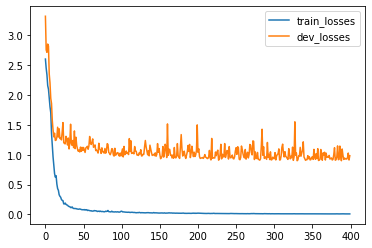

In [ ]:
with open("./result.pkl", "rb") as f:
  result = pkl.load(f)
#画图
df = result.loc[:,["train_losses","dev_losses"]]

df.plot()
plt.show()

In [ ]:
pd.set_option('display.max_columns', None) #显示所有列
pd.set_option('display.max_rows', None) #显示所有行

print(result)

     train_losses  dev_losses  test_maes  test_corrs  test_accs  \
0        2.604475    3.322559   1.445997    0.063093   0.529927   
1        2.451070    2.757319   1.458334    0.104218   0.547445   
2        2.340258    2.717255   1.457540    0.177147   0.560584   
3        2.159589    2.855980   1.426880    0.268915   0.604380   
4        2.099602    2.821632   1.377694    0.337460   0.640876   
5        1.953586    2.353086   1.326939    0.383336   0.661314   
6        1.804030    2.206401   1.278168    0.426317   0.683212   
7        1.706515    1.946442   1.218201    0.480129   0.696350   
8        1.357860    1.860076   1.117955    0.547816   0.745985   
9        1.155092    1.578946   1.029191    0.630905   0.783942   
10       0.965999    1.416269   0.977773    0.681684   0.789781   
11       0.814803    1.299833   0.918530    0.708833   0.798540   
12       0.683191    1.361075   0.879591    0.722197   0.805839   
13       0.624013    1.238963   0.888855    0.728813   0.80292